#**Major assignment (BA885)**
Your company accepts payments over the phone for its services and is now in the process of automating this task. As the sole data scientist on your team, your task is to build and train a voice recognition algorithm to record the customer's credit card number.   



At this time, the accuracy of our Model 3 is 90.6% and we save the model in the destination: '/content/sample_data/save_model/model2.h5'

  
  
  

The basic one is Model 1 (75.72%) and save it in the destination:'/content/sample_data/save_model/model.h5'



*   Model 1(75.72%): use tf.audio.decode_wav to decode the audio file 
  
*   Model 2(78.70%): Include 6 classifiers. `Classifier 1` is to distinguish [0], [9];<br> `Classifier 2` is to distinguish [1], [8]; <br>
`Classifier 3` is to distinguish [2], [7];  
`Classifier 4` is to distinguish [3], [6];  
`Classifier 5` is to distinguish [4], [5];  
then, transfer all the models information into `Classifier 6`, it could recognize [0]~[9]
  
*   Model 3(90.60%): Use the decision tree architecture and convert waveforms to spectrograms



## Import necessary libraries and dataset

Necessary Libraries and Packages

In [ ]:
!pip install tensorflow_io

     |████████████████████████████████| 23.4 MB 1.1 MB/s 


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shutil
import random
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from sklearn.utils import shuffle

In [ ]:
import os
import os.path
from os import path

Load our dataset from the website

In [ ]:
# download the train and test dataset
dataset_links = {'train_val_data': 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
                 'test_data': 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}

In [ ]:
# extract the dataset to colab
for key in dataset_links:
    tf.keras.utils.get_file(key+'.tar.gz',
                            dataset_links[key],
                            cache_dir='./',
                            cache_subdir='datasets/'+key,
                            extract=True)

112574464/112563277 [==============================] - 0s 0us/step


## Create train,val, and test dataset

In [ ]:
# Perform os.walk to list all the files in our dataset and the
# corresponding labels.

train_val_data_paths = []
for folder, labels, samples in os.walk('/content/datasets/train_val_data'):
    for sample in samples:
        if sample[-3:] == 'wav':
            train_val_data_paths.append([folder+'/'+sample, folder[33:]])

In [ ]:
# We wanna see the whole filename
pd.set_option('max_colwidth', 400)

In [ ]:
# Convert the list of files and labels to a DataFrame for further
# analysis

df_train_val = pd.DataFrame(train_val_data_paths,columns=['filename','category'])
df_train_val.head()

,filename,category
0,/content/datasets/train_val_data/no/4c6944d6_nohash_1.wav,no
1,/content/datasets/train_val_data/no/da93deb7_nohash_1.wav,no
2,/content/datasets/train_val_data/no/39ec87ac_nohash_0.wav,no
3,/content/datasets/train_val_data/no/b49caed3_nohash_3.wav,no
4,/content/datasets/train_val_data/no/f6617a86_nohash_1.wav,no


In [ ]:
df_train_val['category'].unique()

array(['no', 'dog', 'sheila', 'six', 'learn', 'visual', 'marvin', 'eight',
       'house', 'backward', 'zero', 'two', 'five', 'on', 'left', 'go',
       'nine', 'follow', 'off', 'seven', 'three', 'wow', 'up', 'cat',
       'yes', 'bird', 'down', 'bed', 'forward', 'four', 'happy',
       '_background_noise_', 'one', 'right', 'stop', 'tree'], dtype=object)

In [ ]:
# Remove "_background_noise_" recordings from the train_val set.

df_train_val = df_train_val.drop(df_train_val[df_train_val['category'] =='_background_noise_'].index)

In [ ]:
df_train_val['category'].unique()

array(['no', 'dog', 'sheila', 'six', 'learn', 'visual', 'marvin', 'eight',
       'house', 'backward', 'zero', 'two', 'five', 'on', 'left', 'go',
       'nine', 'follow', 'off', 'seven', 'three', 'wow', 'up', 'cat',
       'yes', 'bird', 'down', 'bed', 'forward', 'four', 'happy', 'one',
       'right', 'stop', 'tree'], dtype=object)

In [ ]:
test_data_paths = []
for folder, labels, samples in os.walk('/content/datasets/test_data/'):
    for sample in samples:
        if sample[-3:] == 'wav':
            test_data_paths.append([folder+'/'+sample, folder[28:]])

In [ ]:
df_test = pd.DataFrame(test_data_paths,columns=['filename','category'])
df_test.head(5)

,filename,category
0,/content/datasets/test_data/no/b49caed3_nohash_3.wav,no
1,/content/datasets/test_data/no/cd85758f_nohash_2.wav,no
2,/content/datasets/test_data/no/85834399_nohash_2.wav,no
3,/content/datasets/test_data/no/18f8afd5_nohash_3.wav,no
4,/content/datasets/test_data/no/1b4c9b89_nohash_1.wav,no


In [ ]:
df_test['category'].unique()

array(['no', '_unknown_', 'on', 'left', 'go', 'off', 'up', 'yes', 'down',
       '_silence_', 'right', 'stop'], dtype=object)

In [ ]:
# Remove "_silence_" recordings from the test set.
df_test = df_test.drop(df_test[df_test['category'] =='_silence_'].index)

In [ ]:
# and "_unknown_"
df_test = df_test.drop(df_test[df_test['category'] =='_unknown_'].index)

In [ ]:
df_test['category'].unique()

array(['no', 'on', 'left', 'go', 'off', 'up', 'yes', 'down', 'right',
       'stop'], dtype=object)

In [ ]:
# Vectorize the labels by creating a dictionary as follows:

labels_dict = {df_train_val['category'].unique()[i]:i for i in range(len(df_train_val['category'].unique()))}
labels_lookup = {y:x for x,y in labels_dict.items()}

In [ ]:
labels_lookup

{0: 'no',
 1: 'dog',
 2: 'sheila',
 3: 'six',
 4: 'learn',
 5: 'visual',
 6: 'marvin',
 7: 'eight',
 8: 'house',
 9: 'backward',
 10: 'zero',
 11: 'two',
 12: 'five',
 13: 'on',
 14: 'left',
 15: 'go',
 16: 'nine',
 17: 'follow',
 18: 'off',
 19: 'seven',
 20: 'three',
 21: 'wow',
 22: 'up',
 23: 'cat',
 24: 'yes',
 25: 'bird',
 26: 'down',
 27: 'bed',
 28: 'forward',
 29: 'four',
 30: 'happy',
 31: 'one',
 32: 'right',
 33: 'stop',
 34: 'tree'}

In [ ]:
# Make sure only audio files are listed in our data frame.
print(all(df_train_val['filename'].apply(lambda row: row[-3:]=='wav')))
print(all(df_test['filename'].apply(lambda row: row[-3:]=='wav')))

True
True


In [ ]:
# Lastly, shuffle the data before we split it into training,
# validation and test sets.
df_train_val = df_train_val.sample(frac=1)

In [ ]:
len(df_train_val)

105829

In [ ]:
# Split the data into training, and valid datasets.

train_paths = np.array(df_train_val['filename'])[:80000]
train_labels = np.array([labels_dict[x] for x in df_train_val['category']])[0:80000]

valid_paths = np.array(df_train_val['filename'])[80000:]
valid_labels = np.array([labels_dict[x] for x in df_train_val['category']])[80000:]

In [ ]:
len(set(train_labels))

35

In [ ]:
# build a np array about the X and Y of our future model from test set
test_paths=np.array(df_test['filename'])
test_labels = np.array([labels_dict[x] for x in df_test['category']])

In [ ]:
set(test_labels)

{0, 13, 14, 15, 18, 22, 24, 26, 32, 33}

## Model 1
> use tf.audio.decode_wav to decode the audio file

In [ ]:
# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# Seed to use when shuffling the dataset
SHUFFLE_SEED = 885

BATCH_SIZE = 128
EPOCHS = 30

In [ ]:
#Constructs a dataset of audios and labels
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [ ]:
# Reads and decodes an audio file
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

In [ ]:
# transfer the audio files
def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [ ]:
# Create 3 datasets,  training, validation, and test
train_ds = paths_and_labels_to_dataset(train_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

test_ds = paths_and_labels_to_dataset(test_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

In [ ]:
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# build the model
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
# create model
model = build_model((SAMPLING_RATE // 2, 1), 35)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_19 (Conv1D)             (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation_13 (Activation)     (None, 8000, 16)     0           ['conv1d_19[0][0]']              
                                                                                                  
 conv1d_20 (Conv1D)             (None, 8000, 16)     784         ['activation_13[0][0]']          
                                                                                            

In [ ]:
# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
# create a destinate Path to store the model
if path.exists('/content/sample_data/save_model') == False:
  os.mkdir('/content/sample_data/save_model')

os.chdir('/content/sample_data/save_model')

In [ ]:
# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "/content/sample_data/save_model/model.h5"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/30
625/625 [==============================] - 229s 360ms/step - loss: 1.9248 - accuracy: 0.4449 - val_loss: 1.3803 - val_accuracy: 0.6020
Epoch 2/30
625/625 [==============================] - 226s 358ms/step - loss: 1.2053 - accuracy: 0.6450 - val_loss: 1.1203 - val_accuracy: 0.6783
Epoch 3/30
625/625 [==============================] - 226s 359ms/step - loss: 0.9426 - accuracy: 0.7208 - val_loss: 0.9808 - val_accuracy: 0.7189
Epoch 4/30
625/625 [==============================] - 226s 358ms/step - loss: 0.7665 - accuracy: 0.7686 - val_loss: 1.0182 - val_accuracy: 0.7101
Epoch 5/30
625/625 [==============================] - 226s 358ms/step - loss: 0.6368 - accuracy: 0.8058 - val_loss: 1.0437 - val_accuracy: 0.7321
Epoch 6/30
625/625 [==============================] - 226s 358ms/step - loss: 0.5205 - accuracy: 0.8388 - val_loss: 1.0621 - val_accuracy: 0.7300
Epoch 7/30
625/625 [==============================] - 226s 359ms/step - loss: 0.4187 - accuracy: 0.8679 - val_loss: 1.1803 -

In [ ]:
model.evaluate(test_ds)

128/128 [==============================] - 9s 65ms/step - loss: 0.7936 - accuracy: 0.7572


[0.7935917377471924, 0.7572410702705383]

## Method 2
> Include 6 classifiers. `Classifier 1` is to distinguish [0], [9];<br> `Classifier 2` is to distinguish [1], [8]; <br>
`Classifier 3` is to distinguish [2], [7];  
`Classifier 4` is to distinguish [3], [6];  
`Classifier 5` is to distinguish [4], [5];  
then, transfer all the models information into `Classifier 6`, it could recognize [0]~[9]

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
# make subset's labels
sub_train_labels = train_labels[np.where((train_labels == 0) | (train_labels == 1)| (train_labels == 2)| (train_labels == 7))]
sub_test_labels = test_labels[np.where((test_labels == 0) | (test_labels == 1)| (test_labels == 2)| (test_labels == 7))]

In [ ]:
# make subset's features
condition_train = (train_labels == 0) | (train_labels == 1)| (train_labels == 2)| (train_labels == 7)
condition_test = (test_labels == 0) | (test_labels == 1)| (test_labels == 2)| (test_labels == 7)

sub_train_images = train_images[condition_train]
sub_test_images = test_images[condition_test]

In [ ]:
# Reshape and normalize the subset's imag
sub_train_images = sub_train_images.reshape((len(sub_train_images), 28 * 28))
sub_train_images = sub_train_images.astype("float32") / 255
sub_test_images = sub_test_images.reshape((len(sub_test_images), 28 * 28))
sub_test_images = sub_test_images.astype("float32") / 255

Build step by step models

In [ ]:
# make a function to store decision tree's labels
def decision_labels(labels, d0, d1, other1=[],other2=[]):
    if other1:
        x = 3
    else:
        x = 2
    num_samples = labels.shape[0]
    new_labels = np.zeros(shape=(num_samples, x))
    for i in range(num_samples):
        if labels[i] in d0:
            new_labels[i, 0] += 1
        elif labels[i] in d1:
            new_labels[i, 1] += 1
        else:
            new_labels[i, 2] += 1
    return new_labels

def decision_labels2(labels, d0, d1,d2,d3):
    num_samples = labels.shape[0]
    new_labels = np.zeros(shape=(num_samples, 4))
    for i in range(num_samples):
        if labels[i] in d0:
            new_labels[i, 0] += 1
        elif labels[i] in d1:
            new_labels[i, 1] += 1
        elif labels[i] in d2:
            new_labels[i, 2] += 1
        else:
            new_labels[i, 3] += 1
    return new_labels

model_input = layers.Input(shape=28*28)

In [ ]:
# make function to load a part of model(tree_branch)
class tree_branch(keras.Model):
    def __init__(self, mask):
        super().__init__()
        self.cc = layers.Concatenate(axis=1)
        self.hl = layers.Dense(512, activation='relu')
        self.out = layers.Dense(3, activation='softmax')

    def call(self, inputs):
        output = self.cc(inputs)
        output = self.hl(output)
        output = self.out(output)
        return output

class tree_branch2(keras.Model):
    def __init__(self, mask):
        super().__init__()
        self.cc = layers.Concatenate(axis=1)
        self.hl = layers.Dense(512, activation='relu')
        self.out = layers.Dense(4, activation='softmax')

    def call(self, inputs):
        output = self.cc(inputs)
        output = self.hl(output)
        output = self.out(output)
        return output

In [ ]:
# We first need a function to load an audio file as an array.
def load_audio(filepath):
    audio = tfio.audio.AudioIOTensor(filepath)
    audio_rate = int(audio.rate)
 #   assert audio_rate == 16000
    audio = audio.to_tensor().numpy() / 32767.0
    len = audio.shape[0]
    # Padding
    if len == 16000:
        return audio
    elif len < 16000:
        return np.concatenate([audio, 
                               np.zeros(shape=(16000-len, 1),
                                        dtype="float64")], 
                              axis=0)
    else:
        return audio[0:16000]

In [ ]:
class audio_gen(keras.utils.Sequence):
    def __init__(self, file_paths, labels,
                 batch_size=128, shape=(16000,1),
                 shuffle_on_epoch_end=True):
        # Initialization
        super().__init__()
        self.shape = shape
        self.batch_size = batch_size
        self.labels = labels
        self.paths = file_paths
        self.n_channels = shape[-1]
        self.n_classes = max(labels)+1
        self.shuffle = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[self.batch_size * idx: 
                                 self.batch_size * (idx+1)]
        batch_labels = self.labels[self.batch_size * idx:
                                   self.batch_size * (idx+1)]
        batch_samples = np.zeros(shape=(0, self.shape[0], self.shape[1]), 
                                 dtype='float32')
        for path in batch_paths:
            batch_samples = np.concatenate([batch_samples, [load_audio(path)]], 
                                           axis=0)
        return batch_samples, np.array(batch_labels, dtype='int')

    def on_epoch_end(self):
        # suffle the d
        if self.shuffle:
            self.paths, self.labels = shuffle(self.paths, self.labels)

In [ ]:
# Build a dataset generator for each dataset.

train_gen = audio_gen(train_paths, train_labels)
valid_gen = audio_gen(valid_paths, valid_labels)
test_gen = audio_gen(test_paths, test_labels)

In [ ]:
n_categories = max(train_labels)+1
inputs = keras.Input(shape=(16000,1))
x = layers.Conv1D(32, 128, strides=64, activation="relu", padding="same")(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64, 64, strides=32, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(n_categories, activation="softmax")(x)

model = keras.Model(inputs, x)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16000, 1)]        0         
                                                                 
 conv1d_36 (Conv1D)          (None, 250, 32)           4128      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 125, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 4, 64)             131136    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 35)                2275

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(train_gen, validation_data=valid_gen, validation_steps=1,
          epochs=20)

Epoch 1/20
625/625 [==============================] - 140s 223ms/step - loss: 2.9903 - accuracy: 0.1590 - val_loss: 2.6801 - val_accuracy: 0.2266
Epoch 2/20
625/625 [==============================] - 127s 203ms/step - loss: 2.3695 - accuracy: 0.3293 - val_loss: 2.1670 - val_accuracy: 0.3828
Epoch 3/20
625/625 [==============================] - 129s 206ms/step - loss: 1.9704 - accuracy: 0.4541 - val_loss: 1.9356 - val_accuracy: 0.5703
Epoch 4/20
625/625 [==============================] - 128s 204ms/step - loss: 1.7375 - accuracy: 0.5218 - val_loss: 1.8895 - val_accuracy: 0.4453
Epoch 5/20
625/625 [==============================] - 127s 202ms/step - loss: 1.5777 - accuracy: 0.5678 - val_loss: 1.6612 - val_accuracy: 0.6250
Epoch 6/20
625/625 [==============================] - 127s 203ms/step - loss: 1.4547 - accuracy: 0.6006 - val_loss: 1.8161 - val_accuracy: 0.5469
Epoch 7/20
625/625 [==============================] - 130s 209ms/step - loss: 1.3574 - accuracy: 0.6269 - val_loss: 1.5699 -

In [ ]:
model.evaluate(test_gen)

31/31 [==============================] - 6s 205ms/step - loss: 0.8495 - accuracy: 0.7870


[0.8495050072669983, 0.7870463728904724]

## Method 3
> Convert waveforms to spectrograms

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 885
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/datasets/train_val_data'
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
# Find all the categories in the dataset
Commands = np.array(tf.io.gfile.listdir(str(data_dir)))
Commands = Commands[Commands != 'README.md']
Commands = Commands[Commands != '_background_noise_']
Commands = Commands[Commands != 'testing_list.txt']
Commands = Commands[Commands != 'validation_list.txt']
Commands = Commands[Commands != 'LICENSE']
Commands = Commands[Commands != 'train_val_data.tar.gz']
Commands = Commands[Commands != '.DS_Store']
print('Commands:', Commands)

Commands: ['no' 'dog' 'sheila' 'six' 'learn' 'visual' 'marvin' 'eight' 'house'
 'backward' 'zero' 'two' 'five' 'on' 'left' 'go' 'nine' 'follow' 'off'
 'seven' 'three' 'wow' 'up' 'cat' 'yes' 'bird' 'down' 'bed' 'forward'
 'four' 'happy' 'one' 'right' 'stop' 'tree']


In [ ]:
len(Commands)

35

In [ ]:
#Split filenames into train, val and test sets
train_files = train_paths
val_files = valid_paths
test_files = test_paths

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 80000
Validation set size 25829
Test set size 4074


In [ ]:
# check our file's shape. 1 means mono and 2 means stereo
test_file = tf.io.read_file('/content/datasets/train_val_data/bed/00176480_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [ ]:
# build the function to preprocesses the dataset's raw WAV audio files into audio tensors
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [ ]:
# create the function that creates labels using the parent directories for each file
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
# use the decode_audio and get label functions to decode our files
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
# Create a tf.data.Dataset with Dataset.from_tensor_slices and Dataset.map, using get_waveform_and_label defined earlie
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

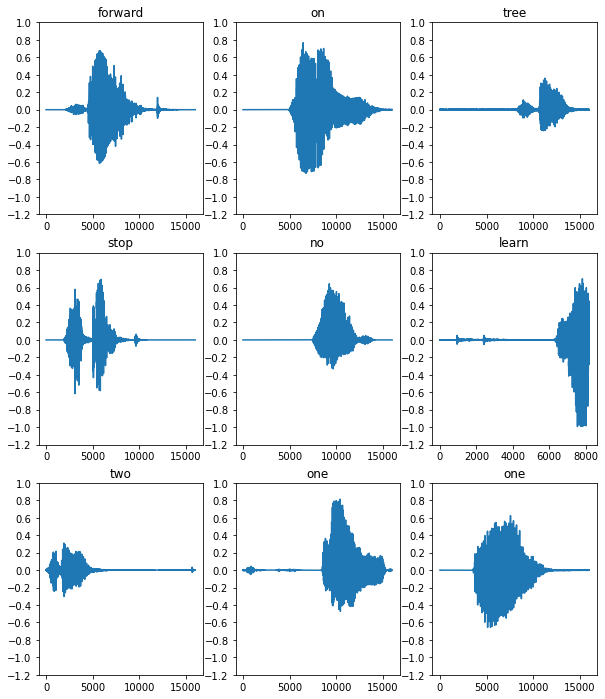

In [ ]:
# plot a few audio waveforms
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
#Create a utility function for converting waveforms to spectrograms
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
# Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: forward
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
# define a function for displaying a spectrogram
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

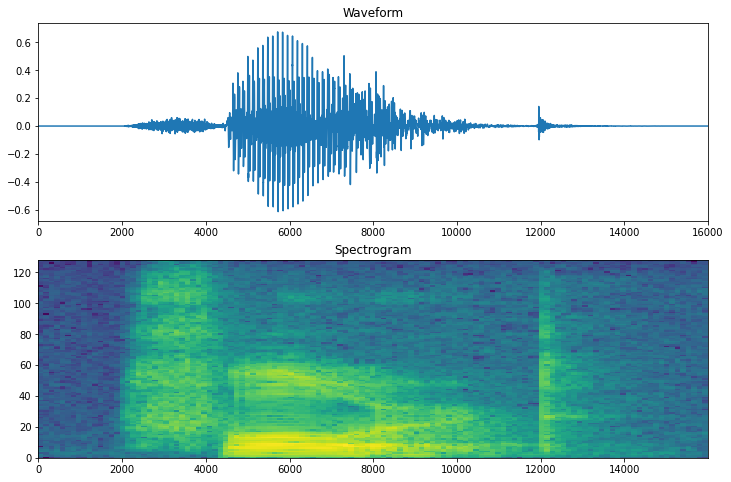

In [ ]:
# Plot the example's waveform over time and the corresponding spectrogram
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
# define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == Commands)
  return spectrogram, label_id

In [ ]:
# Map get_spectrogram_and_label_id across the dataset's elements with Dataset.map
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

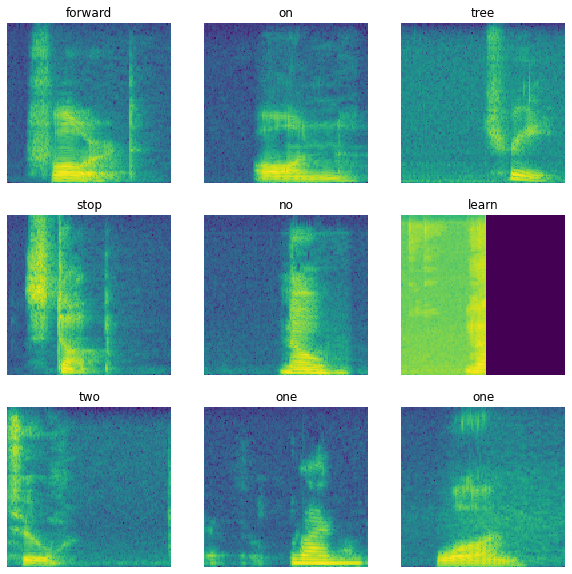

In [ ]:
# Examine the spectrograms for different examples of the dataset
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(Commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
# Repeat the training set preprocessing on the validation and test sets
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
# Batch the train,test, and val sets for model training
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [ ]:
# Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [ ]:
# For this model, we will use a simple convolutional neural network (CNN) as we have converted the audio file into a spectral image.

# our tf.keras.Sequential model will use the following Keras pre-processing layers.

# tf.keras.layer.Resizing: Downsamples the input so that the model can be trained faster.
# tf.keras.layer.Normalisation: normalises each pixel in the image according to the mean and standard deviation of the image.
# For the normalisation layer, its adaptation method first needs to be called on the training data in order to calculate the overall statistics
# (i.e. mean and standard deviation).

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(Commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [ ]:
# Configure the Keras model with the Adam optimizer and the cross-entropy loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
model_save_filename2 = "/content/sample_data/save_model/model2.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename2, monitor="val_accuracy", save_best_only=True
)

In [ ]:
# Train the model over 10 epochs for demonstration purposes
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb]
)

Epoch 1/10
1250/1250 [==============================] - 61s 48ms/step - loss: 2.0663 - accuracy: 0.4140 - val_loss: 1.0691 - val_accuracy: 0.7036
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2808 - accuracy: 0.6210 - val_loss: 0.8275 - val_accuracy: 0.7619
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0780 - accuracy: 0.6772 - val_loss: 0.7359 - val_accuracy: 0.7924
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9556 - accuracy: 0.7110 - val_loss: 0.6769 - val_accuracy: 0.8087
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8785 - accuracy: 0.7324 - val_loss: 0.6438 - val_accuracy: 0.8189
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8150 - accuracy: 0.7511 - val_loss: 0.6024 - val_accuracy: 0.8303
Epoch 7/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7632 - accuracy: 0.7665 - val_loss: 0.5827 - val_accurac

In [ ]:
# Run the model on the test set and check the model's performance
model.evaluate(test_ds)

64/64 [==============================] - 0s 3ms/step - loss: 0.3352 - accuracy: 0.9060


[0.3351621627807617, 0.9059891700744629]

## Failed Try but maybe useful in the future

### try to transfer all audio file to 16kHz

In [ ]:
# import librosa 
# import glob
# from tqdm import tqdm 
# import os

In [ ]:
# !pip install ffmpeg
# import ffmpeg

In [ ]:
# SamplePath='/content/sample_data/dataset2'

In [ ]:
# K16_Path='/content/sample_data/dataset_16k'

In [ ]:
# if path.exists(K16_Path) == False:
#   os.mkdir(K16_Path)

# os.chdir(K16_Path)

In [ ]:
# for i in os.listdir(SamplePath):
#   for j in os.listdir(SamplePath+'/'+i):
#     for wav in os.listdir(SamplePath+'/'+i+'/'+j):
#       wavPath=SamplePath+SamplePath+'/'+i+'/'+j+'/'+wav
#       new_file_path = wavPath.replace('dataset2', 'dataset_16K')
#       if not os.path. exists (new_file_path):
#         os. makedirs (new_file_path) 
#       ffmpeg.input(wavPath).output(new_file_path, ar=16000).run()

In [ ]:
# for wav in tqdm(glob.glob('/content/sample_data/dataset2/train/*.wav')):
#   audio_48k, sr = librosa. load (wav, 48000)
#   audio_16k = librosa.resample(y=audio_48k, orig_sr=sr, target_sr=16000) 
#   print(wav)

In [ ]:
# for wav in tqdm(glob.glob ('/content/sample_data/dataset2/*/*.wav')):
#   audio_48k, sr = librosa. load (wav, 48000)
#   audio_16k = librosa.resample(y=audio_48k, orig_sr=sr, target_sr=16000) 
#   new_filename = wav.replace('/content/sample_data/dataset2', '/content/sample_data/dataset2_16K')
#   new_file_path = new_filename.split(os.sep) [0] + '/' + new_filename.split(os.sep) [1]+'/'
#   if not os.path. exists (new_file_path):
#     os. makedirs (new_file_path) 
#   librosa.output.write_wav(new_filename, audio_16k, 16000)

### Failed to use data generation to improve the performance

In [ ]:
# from keras.models import Sequential
# import keras

In [ ]:
# class DataGenerator(keras.utils.all_utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(None,8000,1), n_channels=1,
#                  n_classes=10, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
# # Parameters
# params = {'dim': (None,8000,1),
#           'batch_size': 64,
#           'n_classes': 6,
#           'n_channels': 1,
#           'shuffle': True}

# # Datasets
# partition = 1
# labels = 1

# # Generators
# training_generator = DataGenerator(partition['train'], labels, **params)
# validation_generator = DataGenerator(partition['validation'], labels, **params)


# # Train model on dataset
# model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=6)

## Reference Website

1. We learned how to use tf.audio.decode_wav to decode the audio file(Model 1) in this website: https://keras.io/examples/audio/speaker_recognition_using_cnn/

2. We learned how to convert waveforms to spectrograms(Model 3) in this website: https://www.tensorflow.org/tutorials/audio/simple_audio

In [ ]:
new_model = tf.keras.models.load_model('/content/model.h5')

In [ ]:
new_model.evaluate(test_ds)

128/128 [==============================] - 9s 65ms/step - loss: nan - accuracy: 0.0015


[nan, 0.0014727540547028184]